深度学习
=============

作业 5
------------

这次作业的目标是用 [Text8](http://mattmahoney.net/dc/textdata)数据集训练一个Word2Vec模型中的skip-gram模型。

In [5]:
#这些都是我们将来会使用到的模块，确保你在进行下一步之前可以导入它们。
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

如果你没有数据，我们将从源网站下载它。

In [6]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """如果文件不在就下载它，并确认它的大小正确"""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


将数据读入并存储为字符串。

In [7]:
def read_data(filename):
  """解压zip文件中的第一个文件并将其存为列表"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


建立一个目录并将稀有词替换为UNK指示物。

In [8]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # 释放内存

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


为skip-gram模型生成训练批(batch)的函数。

In [18]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target标签在buffer中心
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'anarchism', 'a', 'term', 'as', 'originated', 'of']


训练一个skip-gram模型。

In [12]:
batch_size = 128
embedding_size = 128 # 嵌入向量的维度。
skip_window = 1 # 左边和右边有多少词需要考虑。
num_skips = 2 # 重复使用输入来生成标签的次数。
#我们选择一个随机验证集来对最近邻进行采样。在这里我们限制验证集为拥有低数字ID的词，也就是这个数据集里最频繁的词。
valid_size = 16 # 随机的用来验证相似度的词组集
valid_window = 100 #只在分布的前端选择这么多样例
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # 采样的负样本个数。

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入数据.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 变量.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # 模型。
  # 为输入寻找嵌入
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # 每次用一个负标签的样本来计算softmax损失。
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # 优化器.
  # 请注意: 优化器将优化softmax_weights和embeddings变量.
  # 这是因为embeddings被定义为变量
  # 优化器的“最小化”方法将默认修改所有变量,优化器的“最小化”方法将默认修改其通过张量(tensor)的所有变量。
  # 更多细节请参考文档 `tf.train.Optimizer.minimize()`。
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # 计算这一小批样本和所有嵌入之间的相似性。
  # 我们使用cosine距离:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [13]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # 请注意这很费计算 (如果每500步算一次会慢上20%)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # 最近邻的数量
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.907662
Nearest to known: shem, fulbright, anatole, firstnode, basil, dusk, wis, bedding,
Nearest to on: akrotiri, presumably, ware, instilled, schottenheimer, dowager, archbishop, burrito,
Nearest to when: doris, q, mandrakesoft, sensitive, antilles, cameron, groningen, ladies,
Nearest to eight: ladino, staley, sentries, diets, herons, waikato, inconsistently, macaulay,
Nearest to five: abbahu, fat, hesitate, passage, gms, alloying, evolutionists, trivial,
Nearest to only: choke, ashton, finger, modi, bangkok, justifiable, bhindranwale, bijelo,
Nearest to people: waterloo, incumbents, ayman, churchill, brick, connector, repeatedly, perpetrated,
Nearest to were: formic, genealogical, gott, itinerant, dato, utilitarian, exported, prescribing,
Nearest to used: writing, hector, kato, independence, discount, deteriorated, transmitters, synonymously,
Nearest to other: maybe, besides, kzinti, refrigerator, saville, tsunami, burrow, eleusis,
Nearest to was

In [14]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

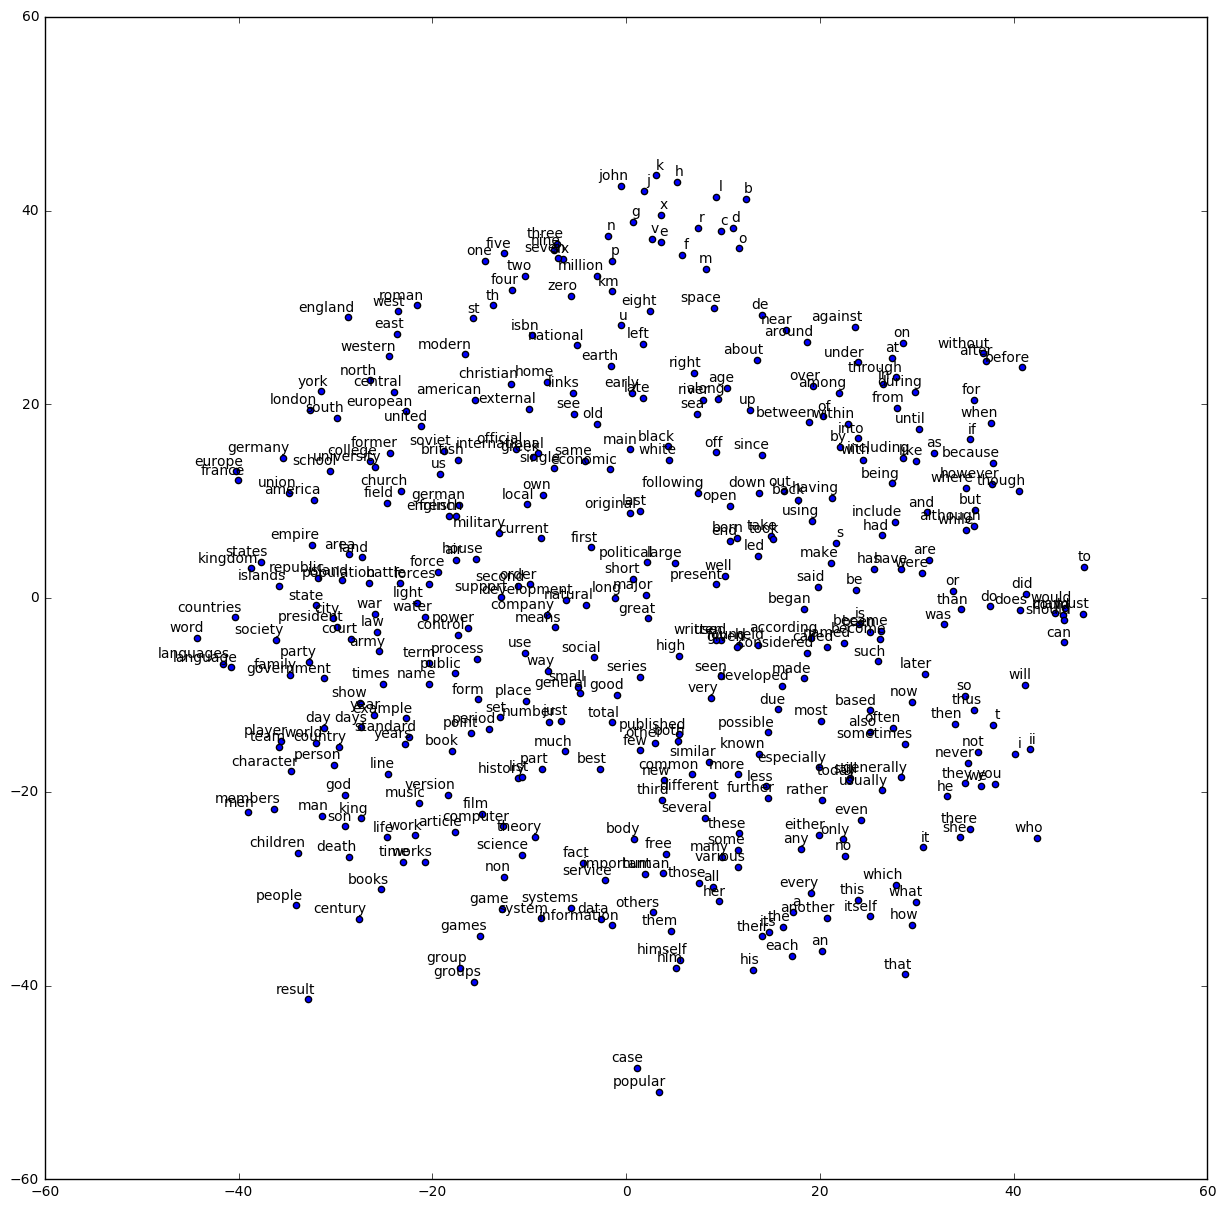

In [15]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # 单位是英尺
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

问题
-------

除了使用skip-gram模型，我们还有另一个Word2Vec模型选择，它的名字叫[CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). 在CBOW模型中，不同于skip-gram模型的从一个词向量中预测一个词的上下文，CBOW从这个词所有的上下文的词向量之和来预测这个词。用text8数据集训练，实现并测试评估CBOW模型的表现。

---